In [1]:
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
from dataset_creation.utils import get_n_random_noises, create_noisy_traces
from snr.calc_snr import CalcSNR, SnrCalcStrategy

## Requirements And Configuration

The generated noisy traces should be a synthetic version of traces taken from the following dataset ('ethz', 'geofon'):

In [2]:
DATASETS_ORIGINS = ['ethz', 'geofon']
dataset_origin = 'ethz'
assert dataset_origin in DATASETS_ORIGINS, f'Expected dataset one of {DATASETS_ORIGINS}. Got {dataset_origin}.'

In [3]:
NUM_SAMPLES=3001                    # Trace sample length - If the dataset is built for phasenet: 3001 If it is for EQTransformer: 6000
NUM_NOISY_VERSIONS_PER_TRACE=1      # How many noisy versions to synthesize using a single real trace
DESIRED_SNR=10                   # What SNR level should the noisy synthesized trace be
SAMPLING_RATE=100                   # Sampling Rate - PhaseNet and EQTransformer expect 100Hz
NUM_OF_ORIGINAL_TRACES = 2000       # How many original traces to use for the noisy dataset - use slice from the start

If the generated noises should allow shifting experiments they should be longer than the original trace.
Define how many 1-second-shifts will the dataset enable.

In [4]:
NUM_SHIFTS=6
AUGMENTED_WINDOW_SIZE=NUM_SAMPLES+SAMPLING_RATE*NUM_SHIFTS

Browse The path of the **event** traces that will be used for synthesizing.

In [5]:
DATASET_PATH=f'/home/moshe/datasets/GFZ/noisy_datasets/{dataset_origin}_{NUM_SAMPLES}_sample_joachim_noises_energy_ratio_snr/'

Browse The path of the **noise** traces that will be used for synthesizing.

In [6]:
NOISES_PATH='/home/moshe/datasets/GFZ/Noises'

In [7]:
dataset_traces_path = os.path.join(DATASET_PATH, 'original_dataset.pt')[:NUM_OF_ORIGINAL_TRACES]
dataset_labels_path = os.path.join(DATASET_PATH, 'original_labels.pt')[:NUM_OF_ORIGINAL_TRACES]

assert os.path.exists(DATASET_PATH), f'Directory {DATASET_PATH} does not exist'
assert os.path.exists(dataset_traces_path), f'file {dataset_traces_path} does not exist'
assert os.path.exists(dataset_labels_path), f'file {dataset_labels_path} does not exist'

## Load Dataset

In [8]:
dataset=torch.load(dataset_traces_path)[:NUM_OF_ORIGINAL_TRACES]
labels=torch.load(dataset_labels_path)[:NUM_OF_ORIGINAL_TRACES]

num_traces = dataset.shape[0]
num_labels = labels.shape[0]
num_samples = dataset.shape[-1]

assert num_labels==num_traces, f'Expected traces equal num labels.Got {num_traces} traces and {num_labels} labels'
assert num_samples==NUM_SAMPLES, f'Expected {NUM_SAMPLES} in each trace. Got {num_samples}.'

print(f'Loaded {num_traces} traces and corresponding labels.')

Loaded 2000 traces and corresponding labels.


## Create a Noisy Dataset

In [9]:
def create_single_noisy_version():
    # prepare full noises traces
    full_noise_traces: torch.tensor = get_n_random_noises(num_noises=num_traces, desired_window_size=AUGMENTED_WINDOW_SIZE, noises_path=NOISES_PATH,force_resample=True, filename='aaa', sampling_rate=SAMPLING_RATE, silent_exception_prints=True).squeeze()
    print(f'Loaded {full_noise_traces.shape[0]} noise traces. shape {full_noise_traces.shape}')
    # Trim the noise traces. Adjust to dataset num samples.
    noise_traces: torch.tensor = full_noise_traces[:,:,:NUM_SAMPLES].clone()

    print(f'Trimmed {noise_traces.shape[0]} noise traces to shape {noise_traces.shape}')
    # Create the noisy traces and get the ones that did not succeed
    version_noised_traces_list, version_noise_factors, version_not_included_indices = create_noisy_traces(dataset=dataset,desired_snr=DESIRED_SNR, labels=labels, noise_traces=noise_traces, calc_snr=CalcSNR(SnrCalcStrategy.ENERGY_RATIO))
    print(f'Created {len(version_noised_traces_list)} noisy traces')
    print(f'The following indices are not included {version_not_included_indices}')
    # Remove the corresponding indices from the full noises list and the label list
    included_indices_list = [i for i in range(num_traces) if i not in version_not_included_indices]
    version_labels = labels[included_indices_list].clone()
    version_full_noise_traces = full_noise_traces[included_indices_list].clone()
    return torch.stack(version_noised_traces_list, dim=0), version_labels, version_full_noise_traces, torch.tensor(version_noise_factors), version_not_included_indices

In [10]:
noised_traces_list, noised_traces_labels_list, augmented_noise_traces_list, factors_list, indices_not_used_list = [],[],[],[], []

In [11]:
pbar = tqdm(range(NUM_NOISY_VERSIONS_PER_TRACE))
for i in pbar:
    version_noised_traces, version_labels, version_full_noise_traces, version_factors, version_not_included_indices =  create_single_noisy_version()
    noised_traces_list.append(version_noised_traces)
    noised_traces_labels_list.append(version_labels.unsqueeze(dim=1))
    augmented_noise_traces_list.append(version_full_noise_traces)
    factors_list.append(version_factors.unsqueeze(dim=1))
    indices_not_used_list.extend(version_not_included_indices)
    pbar.set_description(f'Lists len {len(noised_traces_list), len(noised_traces_labels_list), len(augmented_noise_traces_list), len(factors_list)}')

  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 2000/2000 [00:10<00:00, 187.15it/s]


Created a list of 2000 random noises of shape torch.Size([3, 3601])
stack to tensor
Stacked to tensor of shape torch.Size([2000, 3, 3601])
Loaded 2000 noise traces. shape torch.Size([2000, 3, 3601])
Trimmed 2000 noise traces to shape torch.Size([2000, 3, 3001])



100%|██████████| 2000/2000 [00:04<00:00, 497.99it/s]


Created 2000 noisy traces
The following indices are not included []


In [12]:
noised_traces = torch.vstack(noised_traces_list)
noised_traces_labels = torch.vstack(noised_traces_labels_list).squeeze()
augmented_noise_traces = torch.vstack(augmented_noise_traces_list)
noising_factors = torch.vstack(factors_list).squeeze()
indices_not_used = torch.tensor(list(set(indices_not_used_list)))
noised_traces.shape, noised_traces_labels.shape, augmented_noise_traces.shape, noising_factors.shape, indices_not_used.shape

(torch.Size([2000, 3, 3001]),
 torch.Size([2000]),
 torch.Size([2000, 3, 3601]),
 torch.Size([2000]),
 torch.Size([0]))

In [13]:
noisy_dataset_path = os.path.join(DATASET_PATH,f'noisy_dataset_snr_{DESIRED_SNR}')
noisy_dataset_path

'/home/moshe/datasets/GFZ/noisy_datasets/ethz_3001_sample_joachim_noises_energy_ratio_snr/noisy_dataset_snr_10'

In [14]:
assert os.path.exists(noisy_dataset_path), f'Path {noisy_dataset_path} does not exist.Create it'

In [15]:
torch.save(noised_traces, os.path.join(noisy_dataset_path, 'traces.pt'))
torch.save(augmented_noise_traces, os.path.join(noisy_dataset_path, 'full_noise_traces.pt'))
torch.save(noised_traces_labels, os.path.join(noisy_dataset_path, 'labels.pt'))
torch.save(noising_factors, os.path.join(noisy_dataset_path, 'factors.pt'))
torch.save(indices_not_used, os.path.join(noisy_dataset_path,'indices_not_used'))

## Plot Noising Example

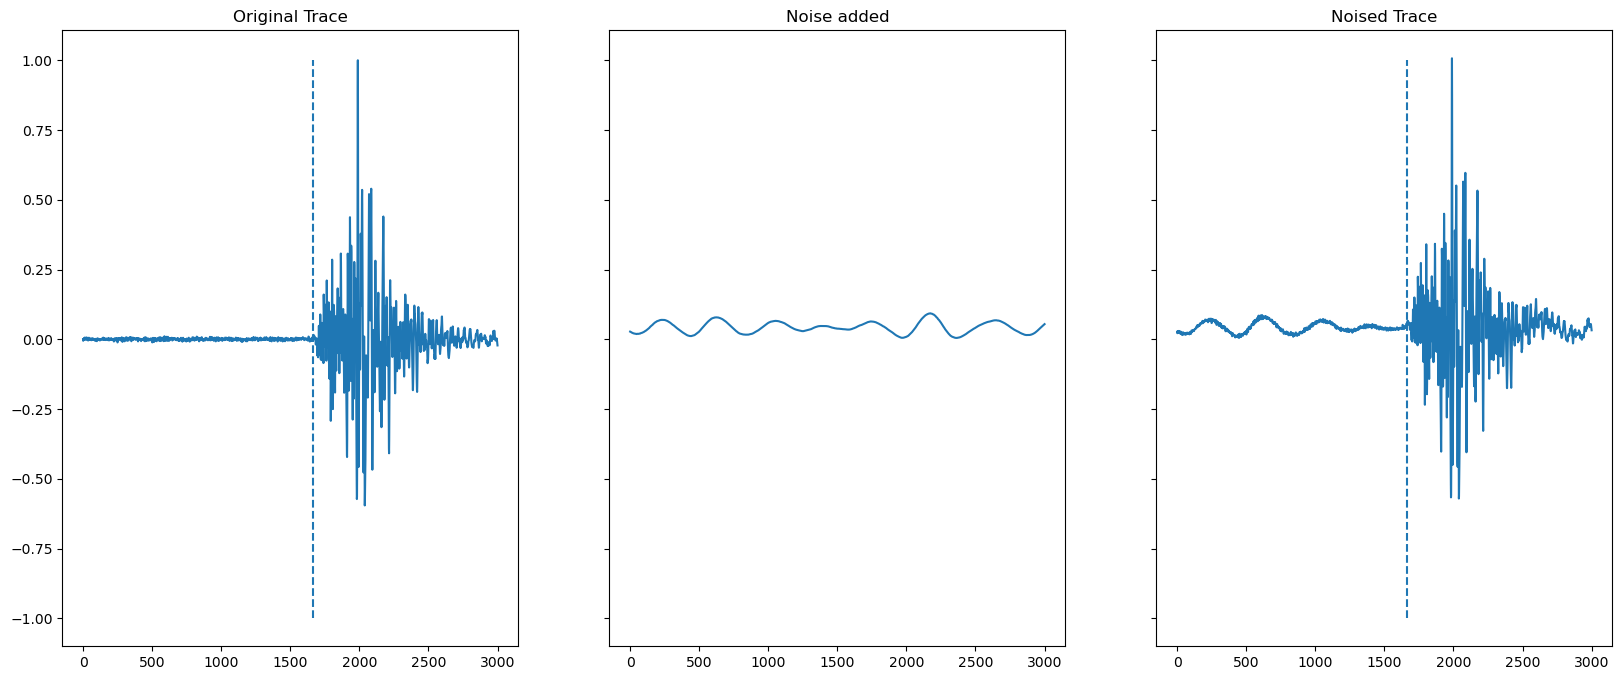

In [16]:
idx = 5
trace  = noised_traces[idx]
label  = noised_traces_labels[idx]
factor = noising_factors[idx]
noise = augmented_noise_traces[idx, :, :trace.shape[-1] ]

fig, (ax_orig,ax_noise, ax_noised) = plt.subplots(1,3,figsize=(20,8), sharey='all')

ax_orig.plot((trace - factor * noise)[0]);
ax_orig.vlines(x=label, ymin=-1, ymax=1,  label='Onset', linestyles='dashed');
ax_orig.set_title('Original Trace')
ax_noise.plot(factor*noise[0]);
ax_noise.set_title('Noise added')
ax_noised.plot(trace[0]);
ax_noised.set_title('Noised Trace')

ax_noised.vlines(x=label, ymin=-1, ymax=1,  label='Onset', linestyles='dashed');


# ax_orig.plot((trace - factor * noise).T)
# ax_orig.vlines(x=label, ymin=-1, ymax=1,  label='Onset', linestyles='dashed')
# ax_noise.plot(noise.T)
# ax_noised.plot(trace.T)
# ax_noised.vlines(x=label, ymin=-1, ymax=1,  label='Onset', linestyles='dashed')